## Deep Learning - Lab 05

* Full name: Đinh Anh Huy
* Student ID: 18110103

### Bài tập 1
**Tìm hiểu về cách dùng của GRU và chạy theo 2 cách theo hướng dẫn.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import io
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

import random
random.seed(1)

In [2]:
def plot_history(model_history, marker=None, figsize=(15,8)):
  plt.style.use("ggplot")
  fig, ax = plt.subplots(1, 2, figsize=figsize) 

  ax[0].plot(model_history.history['loss'], color='b', marker=marker, label='Training Loss')
  ax[0].plot(model_history.history['val_loss'], color='r', marker=marker, label='Validation Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  ax[1].plot(model_history.history['accuracy'], color='b', marker=marker, label='Training  Accuracy')
  ax[1].plot(model_history.history['val_accuracy'], color='r', marker=marker, label='Validation Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

In [3]:
# Download Punkt Tokenizer Models
nltk.download('punkt')

# Download and unzip Glove weigths
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
--2021-11-17 09:59:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-17 09:59:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-17 09:59:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request 

In [4]:
def tokenize(data):
  texts = data.to_list()
  texts = [txt.lower() for txt in texts]
  return [nltk.tokenize.word_tokenize(txt) for txt in texts]

def load_word_embeddings(fname):
  fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
  vocab, matrix = [], []
  i = 0
  for line in fin:
    tokens = line.rstrip().split(' ')
    vocab.append(tokens[0])
    matrix.append(list(map(float, tokens[1:])))
  return vocab, np.asarray(matrix)

def preprocessing_data(data, glove_fname=None):
  __PADDED_INDEX__ = 0
  __UNKNOWN_WORD__ = 1

  tokenized_texts = tokenize(data)

  if glove_fname is None:
    vocab, matrix = load_word_embeddings("glove.6B.100d.txt")
  else:
    vocab, matrix = load_word_embeddings(glove_fname)

  word_to_index = {word: index+2 for index, word in enumerate(vocab)}
  embedding_matrix = np.pad(matrix, pad_width=((2,0),(0,0)), mode='constant', constant_values=0.0)

  X = []
  for text in tokenized_texts:
    cur_text_indices = []
    for word in text:
      if word in word_to_index:
        cur_text_indices.append(word_to_index[word])
      else:
        cur_text_indices.append(__UNKNOWN_WORD__)
    X.append(cur_text_indices)

  return tf.keras.preprocessing.sequence.pad_sequences(sequences=X, padding='post'), embedding_matrix

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [6]:
X, embedding_matrix = preprocessing_data(df['Text'])
y = df['y'].values

# Split data to training, validation and testing set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=43)

print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_valid.shape)

Shape of training set:  (4459, 215)
Shape of validation set:  (1115, 215)


In [7]:
inputs = Input(shape=(None,))

embed = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  embeddings_initializer=tf.keras.initializers.Constant(value=embedding_matrix),
                  trainable=False,
                  mask_zero=True)(inputs)

gru = GRU(units=100,
            return_sequences=False)(embed)

dense = Dense(units=2, activation='softmax')(gru)

model = Model(inputs=inputs, outputs=dense)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         40000200  
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 40,061,002
Trainable params: 60,802
Non-trainable params: 40,000,200
_________________________________________________________________


In [8]:
BATCH_SIZE = 512
EPOCHS = 30
lr = 3e-3
decay = 1e-5

In [9]:
# init Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)

time_start = time.time()

# compile model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# fine-tune the model
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid))

gru_time = time.time() - time_start

Epoch 1/30
9/9 [==============================] - 5s 163ms/step - loss: 0.4367 - accuracy: 0.7876 - val_loss: 0.3189 - val_accuracy: 0.8655
Epoch 2/30
9/9 [==============================] - 0s 20ms/step - loss: 0.2875 - accuracy: 0.8854 - val_loss: 0.2628 - val_accuracy: 0.9139
Epoch 3/30
9/9 [==============================] - 0s 19ms/step - loss: 0.2279 - accuracy: 0.9096 - val_loss: 0.1930 - val_accuracy: 0.9300
Epoch 4/30
9/9 [==============================] - 0s 19ms/step - loss: 0.1464 - accuracy: 0.9511 - val_loss: 0.1263 - val_accuracy: 0.9614
Epoch 5/30
9/9 [==============================] - 0s 19ms/step - loss: 0.0964 - accuracy: 0.9697 - val_loss: 0.1163 - val_accuracy: 0.9632
Epoch 6/30
9/9 [==============================] - 0s 19ms/step - loss: 0.0758 - accuracy: 0.9758 - val_loss: 0.0940 - val_accuracy: 0.9695
Epoch 7/30
9/9 [==============================] - 0s 19ms/step - loss: 0.0619 - accuracy: 0.9800 - val_loss: 0.0914 - val_accuracy: 0.9731
Epoch 8/30
9/9 [==========

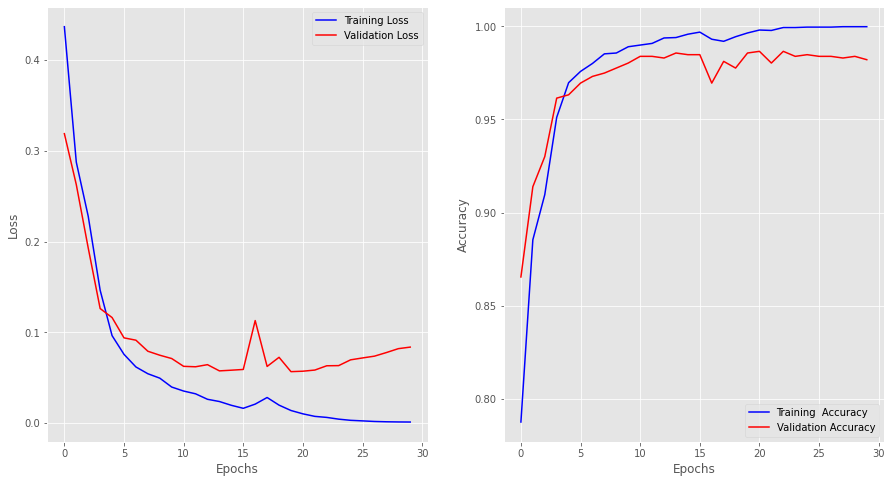

In [10]:
plot_history(history, figsize=(15,8))

In [11]:
inputs_2 = Input(shape=(None,))

embed_2 = Embedding(input_dim=embedding_matrix.shape[0],
                    output_dim=embedding_matrix.shape[1],
                    trainable=False,
                    mask_zero=True)(inputs_2)

gru_2 = GRU(units=100,
              return_sequences=True,
              return_state=True)(embed_2)

global_maxpool = GlobalAveragePooling1D()(gru_2[0])

dense_2 = Dense(units=2, activation='softmax')(global_maxpool)

model_2 = Model(inputs=inputs_2, outputs=dense_2)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         40000200  
                                                                 
 gru_1 (GRU)                 [(None, None, 100),       60600     
                              (None, 100)]                       
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 40,061,002
Trainable params: 60,802
Non-train

In [12]:
# compile model
model_2.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# fine-tune the model
history_2 = model_2.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
9/9 [==============================] - 5s 171ms/step - loss: 0.5506 - accuracy: 0.8208 - val_loss: 0.4415 - val_accuracy: 0.8610
Epoch 2/30
9/9 [==============================] - 0s 21ms/step - loss: 0.3983 - accuracy: 0.8672 - val_loss: 0.3813 - val_accuracy: 0.8610
Epoch 3/30
9/9 [==============================] - 0s 21ms/step - loss: 0.3609 - accuracy: 0.8666 - val_loss: 0.3552 - val_accuracy: 0.8583
Epoch 4/30
9/9 [==============================] - 0s 21ms/step - loss: 0.3334 - accuracy: 0.8650 - val_loss: 0.3359 - val_accuracy: 0.8565
Epoch 5/30
9/9 [==============================] - 0s 20ms/step - loss: 0.3098 - accuracy: 0.8641 - val_loss: 0.3074 - val_accuracy: 0.8556
Epoch 6/30
9/9 [==============================] - 0s 20ms/step - loss: 0.2676 - accuracy: 0.8776 - val_loss: 0.2405 - val_accuracy: 0.9049
Epoch 7/30
9/9 [==============================] - 0s 21ms/step - loss: 0.1998 - accuracy: 0.9193 - val_loss: 0.1761 - val_accuracy: 0.9390
Epoch 8/30
9/9 [==========

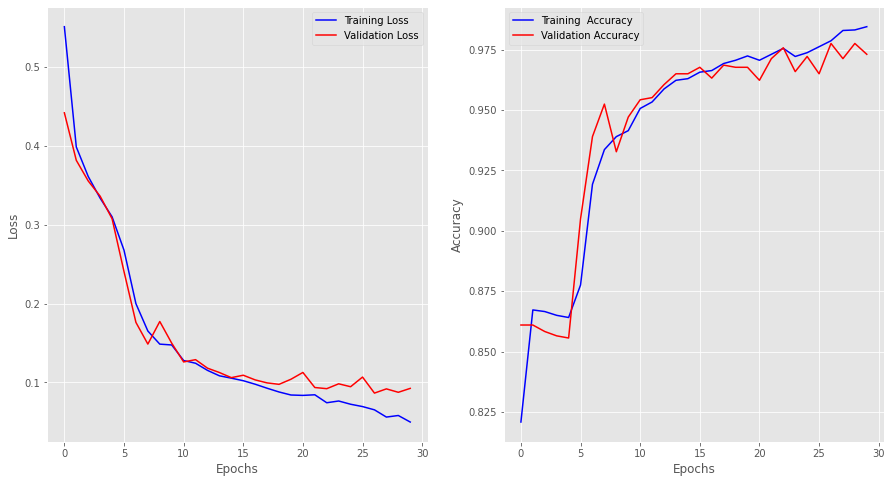

In [13]:
plot_history(history_2, figsize=(15,8))

Từ đồ thị của 2 cách thực hiện GRU trên bộ dữ liệu `spam_detection.csv`, ta thấy rằng mô hình GRU cho ra kết quả khá tốt khi training accuracy và validation accuracy của cả 2 cách đều có giá trị cao hơn 0.95 và cũng không xảy ra trường hợp overfitting.

### Bài tập 2
**So sánh giữa 2 cấu trúc của GRU và LSTM. Từ đó đưa ra kết luận của mình (có dẫn chứng).**

#### Long Short-Term Memory (LSTM)
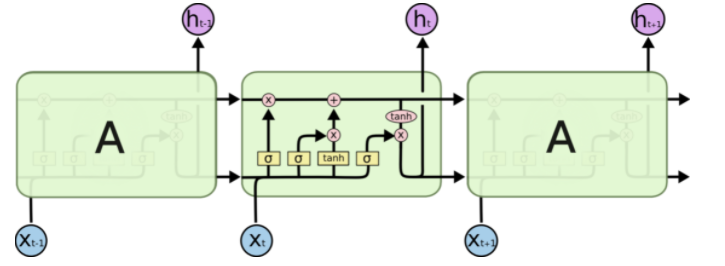

* LSTM là một dạng đặc biệt của RNN có khả năng học được long-term sequences. Nó được thiết kế để có thể ghi nhớ long sequences trong khoảng thời gian dài và nhớ một cách có chọn lọc những thông tin quan trọng ở xa trong quá khứ. LSTM cũng là một phương pháp khắc phục hiện tượng vanishing gradient xảy ra ở RNN truyền thống. 

* Các LSTM cells (ô màu xanh lá) sử dụng các gate để điều chỉnh thông tin được lưu giữ hoặc loại bỏ ở loop operation trước khi chuyển thông tin dài hạn và ngắn hạn qua cell tiếp theo. Có tổng cộng 3 gate mà LSTM sử dụng: 

  * *Input Gate*: gate quyết định những thông tin nào từ current input và short term memory từ cell trước đó sẽ được lưu giữ lại trong long term memory.
  * *Forget Gate*: gate quyết định những thông tin nào trong long term memory sẽ được giữ lại hoặc loại bỏ khỏi long term memory.
  * *Output Gate*: gate sẽ lấy current input, short term memory ở cell trước đó và long term memory vừa được tính để tạo ra short term memory mới để chuyển qua cell tiếp theo.

#### Gated Recurrent Unit (GRU)
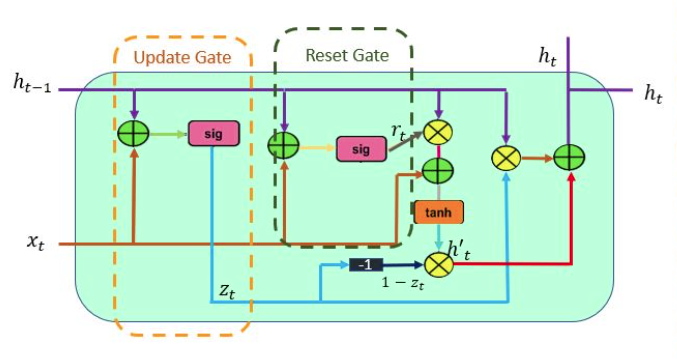

* Chúng ta có thể coi GRU là một phiên bản của LSTM với nguyên tắc hoạt động tương tự như LSTM nhưng có cấu tạo đơn giản hơn. GRU kết hợp Cell state và Hidden state thành một, do đó nó chỉ có 2 input và 1 output. Ngoài ra, trong GRU chúng ta sử dụng 2 gate là: 

  * *Update gate*: chịu trách nhiệm xác định lượng thông tin trước đó cần giữ lại để chuyển qua trạng thái tiếp theo.

  * *Reset gate*: quyết định lượng thông tin trong quá khứ cần thiết để bỏ qua.

#### LSTM vs GRU

Cả 2 mô hình trên đều giải quyết các vấn đề mà RNN truyền thống phải đối mặt là short-term memory và vanishing gradient. Hơn nữa, performance của cả 2 mô hình gần như tương đương nhau. Bên cạnh những điểm tương đồng, vẫn có một số điểm khác nhau giữa hai mô hình này:

* GRU có 2 gates (update gate và reset gate) trong khi LSTM có 3 gates (input gate, forget gate và output gate).

* GRU có cấu trúc đơn giản hơn LSTM khi kết hợp Cell state và Hidden state thành một, do đó GRU không có bộ nhớ trong để lưu giữ thông tin dài hạn mà thực hiện tính toán trực tiếp trên thông tin từ những cell trước đó. Vì vậy GRU sử dụng ít bộ nhớ hơn, nhưng khả năng lưu trữ thông tin dài hạn đối với những chuỗi quá dài sẽ gặp hạn chế hơn LSTM.

* GRU có ít tensor operations hơn, do đó khi train GRU sẽ nhanh hơn (một chút) so với LSTM.

Cả LSTM và GRU đều có những ưu điểm và nhược điểm riêng của mình. Thông thường LSTM có thể lưu trữ thông tin với dữ liệu dài hơn so với GRU. Tuy nhiên, do cấu tạo đơn giản của mình, GRU thưởng xử lý nhanh hơn LSTM và có thể dễ dàng sử dụng để xây dựng các mạng có cấu trúc phức tạp. Do đó, việc sử dụng LSTM hay GRU tuỳ thuộc vào yêu cầu bài toán cụ thể và thông thường chúng ta nên thử cả 2 mô hình này.

#### Example

In [14]:
inputs = Input(shape=(None,))

embed = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  embeddings_initializer=tf.keras.initializers.Constant(value=embedding_matrix),
                  trainable=False,
                  mask_zero=True)(inputs)

lstm = LSTM(units=100,
            return_sequences=False)(embed)

dense = Dense(units=2, activation='softmax')(lstm)

lstm_model = Model(inputs=inputs, outputs=dense)

lstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         40000200  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 40,080,802
Trainable params: 80,602
Non-trainable params: 40,000,200
_________________________________________________________________


In [15]:
time_start = time.time()

# compile model
lstm_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# fine-tune the model
history_lstm = lstm_model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid))

lstm_time = time.time() - time_start

Epoch 1/30
9/9 [==============================] - 5s 171ms/step - loss: 0.3183 - accuracy: 0.8912 - val_loss: 0.1690 - val_accuracy: 0.9363
Epoch 2/30
9/9 [==============================] - 0s 20ms/step - loss: 0.1220 - accuracy: 0.9560 - val_loss: 0.1112 - val_accuracy: 0.9614
Epoch 3/30
9/9 [==============================] - 0s 22ms/step - loss: 0.0839 - accuracy: 0.9733 - val_loss: 0.0873 - val_accuracy: 0.9668
Epoch 4/30
9/9 [==============================] - 0s 21ms/step - loss: 0.0579 - accuracy: 0.9834 - val_loss: 0.1108 - val_accuracy: 0.9668
Epoch 5/30
9/9 [==============================] - 0s 20ms/step - loss: 0.0575 - accuracy: 0.9812 - val_loss: 0.0713 - val_accuracy: 0.9758
Epoch 6/30
9/9 [==============================] - 0s 21ms/step - loss: 0.0407 - accuracy: 0.9890 - val_loss: 0.0691 - val_accuracy: 0.9794
Epoch 7/30
9/9 [==============================] - 0s 21ms/step - loss: 0.0312 - accuracy: 0.9917 - val_loss: 0.0593 - val_accuracy: 0.9812
Epoch 8/30
9/9 [==========

>> Plot line graph for Loss and Accuracy of LSTM.


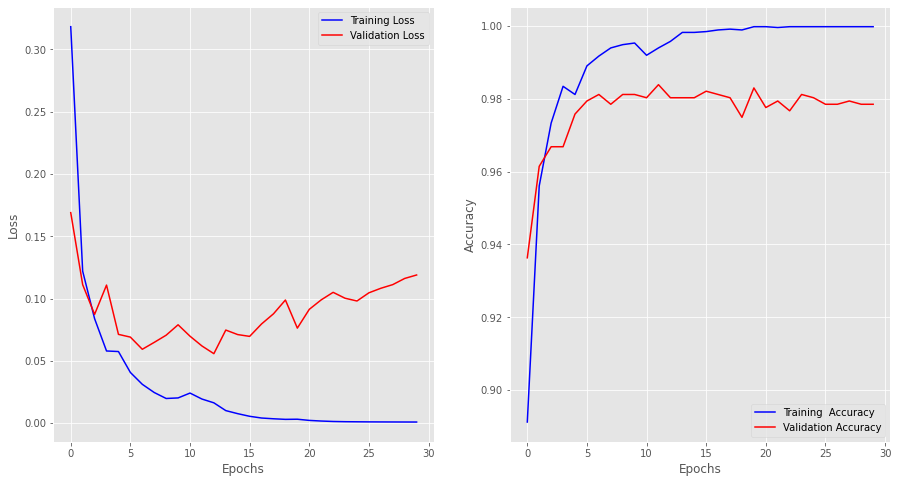

In [16]:
print(">> Plot line graph for Loss and Accuracy of LSTM.")
plot_history(history_lstm, figsize=(15,8))

>> Plot line graph for Loss and Accuracy of GRU.


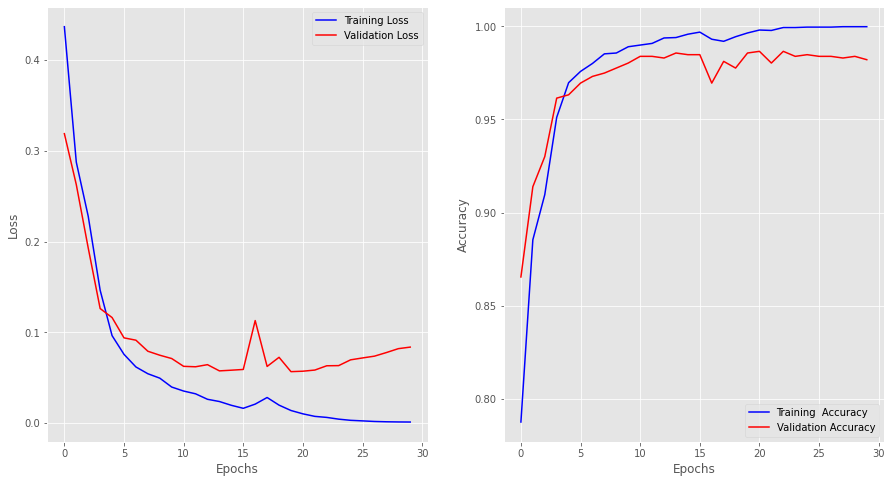

In [17]:
print(">> Plot line graph for Loss and Accuracy of GRU.")
plot_history(history, figsize=(15,8))

In [18]:
print(">> Total time of compile GRU: ", gru_time)
print(">> Total time of compile LSTM: ", lstm_time)

>> Total time of compile GRU:  10.444665431976318
>> Total time of compile LSTM:  13.567283153533936


Ta thực hiện lại yêu cầu bài tập 1 với LSTM, ta nhận thấy rằng: 

* GRU có ít parameters hơn LSTM (GRU có 60600 parameters và LSTM có 80400 parameters).

* Thời gian compile GRU ít hơn (khoảng 3 giây) so với LSTM.

* Performance của LSTM và GRU gần như tương đương nhau khi training accuracy $\approx$ 0.99 và validation accuracy $\approx$ 0.98.
